In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce
import holidays
from stargazer.stargazer import Stargazer
myFmt = mdates.DateFormatter('%m-%d')
plt.rcParams["figure.figsize"] = (11, 5)
np.set_printoptions(suppress=True)

In [2]:
# Load and preprocess the data
demand_df = pd.read_csv(r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 01 - DIPU\Estimation\load\forecast_load.csv")
demand_df = demand_df.rename(columns={'Unnamed: 0': 'date', 'Actual Load': 'load'})
demand_df['date'] = pd.to_datetime(demand_df['date'], utc=True) + pd.DateOffset(hours=1)
demand_df = pd.DataFrame(demand_df.set_index('date')['load'].resample('1h').mean())


In [3]:
demand_df['hour'] = demand_df.index.hour.values.astype(np.int64)
demand_df['year'] = demand_df.index.year.values.astype(np.int64)
demand_df['month'] = demand_df.index.month.values.astype(np.int64)
demand_df['day'] = demand_df.index.day.values.astype(np.int64)
demand_df['date_offset'] = (demand_df.index.month.values * 100 + demand_df.index.day.values - 320) % 1300
demand_df['season'] = pd.cut(demand_df['date_offset'], [0,300, 602, 900, 1300], labels=['spring', 'summer', 'autumn', 'winter'])

demand_df

,load,hour,year,month,day,date_offset,season
date,,,,,,,
2015-01-01 00:00:00+00:00,44600.25,0,2015,1,1,1081,winter
2015-01-01 01:00:00+00:00,43454.75,1,2015,1,1,1081,winter
2015-01-01 02:00:00+00:00,41963.25,2,2015,1,1,1081,winter
2015-01-01 03:00:00+00:00,40617.75,3,2015,1,1,1081,winter
2015-01-01 04:00:00+00:00,39936.75,4,2015,1,1,1081,winter
...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,55785.50,19,2021,12,31,911,winter
2021-12-31 20:00:00+00:00,51848.75,20,2021,12,31,911,winter
2021-12-31 21:00:00+00:00,48751.75,21,2021,12,31,911,winter


In [4]:

demand_df['htype'] = pd.cut(demand_df['hour'], [0, 7, 12, 18, 22, 23], labels=['Off_peak', 'Peak', 'Off_peak', 'Peak', 'Opeak'], ordered=False, include_lowest=True)
demand_df['wday'] = demand_df.index.weekday.values
demand_df['weekday'] = pd.cut(demand_df['wday'], [0, 4, 6], labels=['Wday', 'Wend'], ordered=False, include_lowest=True)
demand_df['wh'] = demand_df['weekday'].astype(str) + "_" + demand_df['htype'].astype(str)
demand_df['date_column'] = demand_df.index
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
             7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

demand_df['day'] = demand_df.index.weekday.map(day_map)
demand_df['month'] = demand_df.index.month.map(month_map)

# Create dummy variables
season_dummies = pd.get_dummies(demand_df['season'])
htype_dummies = pd.get_dummies(demand_df['htype'], prefix='htype')
weekday_dummies = pd.get_dummies(demand_df['weekday'], prefix='weekday')
year_dummies = pd.get_dummies(demand_df['year'], prefix='year')
wh_dummies = pd.get_dummies(demand_df['wh'])
day_dummies = pd.get_dummies(demand_df['day'])
month_dummies = pd.get_dummies(demand_df['month'])
hour_dummies = pd.get_dummies(demand_df['hour'], prefix='hour')

demand_df = pd.merge(demand_df, season_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, htype_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, weekday_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, year_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, wh_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, day_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, month_dummies, left_index=True, right_index=True)
demand_df = pd.merge(demand_df, hour_dummies, left_index=True, right_index=True)

# Add holiday data
holiday_dates = list(holidays.DE(years=demand_df['year'].unique()).keys())
holiday_hours = pd.date_range(start=min(holiday_dates), end=max(holiday_dates) + pd.DateOffset(days=1), freq='h')
holidays_date = pd.DataFrame(holiday_hours, columns=['date_column'])
holidays_date['holiday'] = holidays_date['date_column'].dt.date.isin(holiday_dates)
holidays_date['date_column'] = pd.to_datetime(holidays_date['date_column'], utc=True)
demand_df = pd.merge(demand_df, holidays_date, how='left')
demand_df['holiday'] = demand_df['holiday'].fillna(0)
holidays_dummies = pd.get_dummies(demand_df['holiday'], prefix='holidays')

# Merge all dummy variables into the original dataframe using pd.merge

demand_df = pd.merge(demand_df, holidays_dummies, left_index=True, right_index=True)
demand_df['time'] = range(len(demand_df))
demand_df['covid'] = demand_df['spring']*demand_df['year_2020']

demand_df

,load,hour,year,month,day,date_offset,season,htype,wday,weekday,...,hour_19,hour_20,hour_21,hour_22,hour_23,holiday,holidays_False,holidays_True,time,covid
0,44600.25,0,2015,January,Thursday,1081,winter,Off_peak,3,Wday,...,False,False,False,False,False,True,False,True,0,False
1,43454.75,1,2015,January,Thursday,1081,winter,Off_peak,3,Wday,...,False,False,False,False,False,True,False,True,1,False
2,41963.25,2,2015,January,Thursday,1081,winter,Off_peak,3,Wday,...,False,False,False,False,False,True,False,True,2,False
3,40617.75,3,2015,January,Thursday,1081,winter,Off_peak,3,Wday,...,False,False,False,False,False,True,False,True,3,False
4,39936.75,4,2015,January,Thursday,1081,winter,Off_peak,3,Wday,...,False,False,False,False,False,True,False,True,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61363,55785.50,19,2021,December,Friday,911,winter,Peak,4,Wday,...,True,False,False,False,False,0,True,False,61363,False
61364,51848.75,20,2021,December,Friday,911,winter,Peak,4,Wday,...,False,True,False,False,False,0,True,False,61364,False
61365,48751.75,21,2021,December,Friday,911,winter,Peak,4,Wday,...,False,False,True,False,False,0,True,False,61365,False
61366,47461.25,22,2021,December,Friday,911,winter,Peak,4,Wday,...,False,False,False,True,False,0,True,False,61366,False


In [43]:
#
filtered_demand_opeak = demand_df[(demand_df['htype'] == 'Off_peak') & (demand_df['year'] == 2021)]
filtered_demand_peak = demand_df[(demand_df['htype'] == 'Peak') & (demand_df['year'] == 2021)]

p_coef = filtered_demand_peak['load'].mean()/filtered_demand_opeak['load'].mean()
print(p_coef)
mean_load_by_month = np.array(filtered_demand_peak.groupby('month')['load'].mean())

np.vstack([mean_load_by_month * 1.01**t for t in range(20)]).reshape(len(mean_load_by_month)*20)

1.0994063118847284


array([65055.37455197, 66236.9781746 , 64703.75985663, 60551.75555556,
       57558.37365591, 58350.37222222, 58071.84139785, 56507.64516129,
       58415.02685185, 61303.44982079, 65026.03148148, 64140.27867384,
       65705.92829749, 66899.34795635, 65350.7974552 , 61157.27311111,
       58133.95739247, 58933.87594444, 58652.55981183, 57072.7216129 ,
       58999.17712037, 61916.484319  , 65676.2917963 , 64781.68146057,
       66362.98758047, 67568.34143591, 66004.30542975, 61768.84584222,
       58715.2969664 , 59523.21470389, 59239.08540995, 57643.44882903,
       59589.16889157, 62535.64916219, 66333.05471426, 65429.49827518,
       67026.61745627, 68244.02485027, 66664.34848405, 62386.53430064,
       59302.44993606, 60118.44685093, 59831.47626405, 58219.88331732,
       60185.06058049, 63161.00565381, 66996.3852614 , 66083.79325793,
       67696.88363083, 68926.46509877, 67330.99196889, 63010.39964365,
       59895.47443542, 60719.63131944, 60429.79102669, 58802.0821505 ,
      

In [37]:
mean_load_by_month*1.023

array([66.55164817, 67.76042867, 66.19194633, 61.94444593, 58.88221625,
       59.69243078, 59.40749375, 57.807321  , 59.75857247, 62.71342917,
       66.52163021, 65.61550508])

In [6]:
### Ancienne estimation

X = demand_df[['holidays_True', 'winter', 'summer', 'autumn', 'Wday_Opeak', 'Wend_Peak', 'Wend_Off_peak',
     'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'covid']]
X = sm.add_constant(X)
Y = demand_df[['load']]/1000 # GWh

model = sm.OLS(Y,X.astype(float))
results = model.fit()
print(results.summary())

demand_df['fitted']=results.fittedvalues*1000
demand_df['residuals']= demand_df['load']-demand_df['fitted']


print_results = Stargazer([results])
print_results.render_latex()


                            OLS Regression Results                            
Dep. Variable:                   load   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     2555.
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:55:18   Log-Likelihood:            -2.1435e+05
No. Observations:               61368   AIC:                         4.287e+05
Df Residuals:                   61353   BIC:                         4.289e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            58.8195      0.106    552.567

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable: load}} \\\n\\cr \\cline{2-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n Wday_Opeak & -9.575$^{***}$ \\\\\n& (0.190) \\\\\n Wend_Off_peak & -12.635$^{***}$ \\\\\n& (0.088) \\\\\n Wend_Peak & -7.620$^{***}$ \\\\\n& (0.105) \\\\\n autumn & 3.871$^{***}$ \\\\\n& (0.096) \\\\\n const & 58.819$^{***}$ \\\\\n& (0.106) \\\\\n covid & -2.912$^{***}$ \\\\\n& (0.211) \\\\\n holidays_True & -12.593$^{***}$ \\\\\n& (0.208) \\\\\n summer & -1.489$^{***}$ \\\\\n& (0.095) \\\\\n winter & 5.056$^{***}$ \\\\\n& (0.096) \\\\\n year_2016 & 0.058$^{}$ \\\\\n& (0.120) \\\\\n year_2017 & 0.626$^{***}$ \\\\\n& (0.120) \\\\\n year_2018 & 1.020$^{***}$ \\\\\n& (0.120) \\\\\n year_2019 & -0.335$^{***}$ \\\\\n& (0.120) \\\\\n year_2020 & -1.141$^{***}$ \\\\\n& (0.131) \\\\\n year_2021 & 0.490$^{***}$ \\\\\n& (0.120) \\\\\n\\hline \\\\[-1

In [7]:
#### Nouvelle estimation

# Référence dummies : Vendredi 15 mai 2015 à 8h

X = demand_df[['holidays_True', 'Wday_Opeak', 'Wend_Peak', 'Wend_Off_peak',
     'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'time', 'covid', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']]

X = sm.add_constant(X)
Y = demand_df[['load']]/1000 # GWh

model = sm.OLS(Y,X.astype(float))
results = model.fit()
print(results.summary())

demand_df['fitted']=results.fittedvalues*1000
demand_df['residuals']= demand_df['load']-demand_df['fitted']


print_results = Stargazer([results])
print_results.render_latex()



                            OLS Regression Results                            
Dep. Variable:                   load   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     7506.
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:55:18   Log-Likelihood:            -1.6769e+05
No. Observations:               61368   AIC:                         3.355e+05
Df Residuals:                   61316   BIC:                         3.360e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            69.3690      0.164    422.965

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable: load}} \\\n\\cr \\cline{2-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n April & -2.891$^{***}$ \\\\\n& (0.091) \\\\\n August & -2.645$^{***}$ \\\\\n& (0.272) \\\\\n December & 5.971$^{***}$ \\\\\n& (0.476) \\\\\n February & 1.839$^{***}$ \\\\\n& (0.090) \\\\\n January & 0.880$^{***}$ \\\\\n& (0.125) \\\\\n July & -2.520$^{***}$ \\\\\n& (0.221) \\\\\n June & -3.143$^{***}$ \\\\\n& (0.173) \\\\\n May & -3.292$^{***}$ \\\\\n& (0.128) \\\\\n Monday & -0.122$^{**}$ \\\\\n& (0.056) \\\\\n November & 6.395$^{***}$ \\\\\n& (0.425) \\\\\n October & 3.051$^{***}$ \\\\\n& (0.373) \\\\\n Saturday & -5.614$^{***}$ \\\\\n& (0.063) \\\\\n September & -0.445$^{}$ \\\\\n& (0.322) \\\\\n Sunday & -9.311$^{***}$ \\\\\n& (0.063) \\\\\n Thursday & 1.109$^{***}$ \\\\\n& (0.056) \\\\\n Tuesday & 1.262$^{***}$ \\\\\n& (0.056) \\\\\n 

In [8]:
wind = 144
load_smoothed = demand_df['load'].rolling(window=wind)
fit_smoothed = demand_df['fitted'].rolling(window=wind)
load_smoothed = load_smoothed.mean()/1000
fit_smoothed = fit_smoothed.mean()/1000

In [9]:
print(demand_df['date_column'])

0       2015-01-01 00:00:00+00:00
1       2015-01-01 01:00:00+00:00
2       2015-01-01 02:00:00+00:00
3       2015-01-01 03:00:00+00:00
4       2015-01-01 04:00:00+00:00
                   ...           
61363   2021-12-31 19:00:00+00:00
61364   2021-12-31 20:00:00+00:00
61365   2021-12-31 21:00:00+00:00
61366   2021-12-31 22:00:00+00:00
61367   2021-12-31 23:00:00+00:00
Name: date_column, Length: 61368, dtype: datetime64[ns, UTC]


In [10]:
demand_df['date_column'] = pd.to_datetime(demand_df['date_column'])
demand_df = demand_df.set_index('date_column')


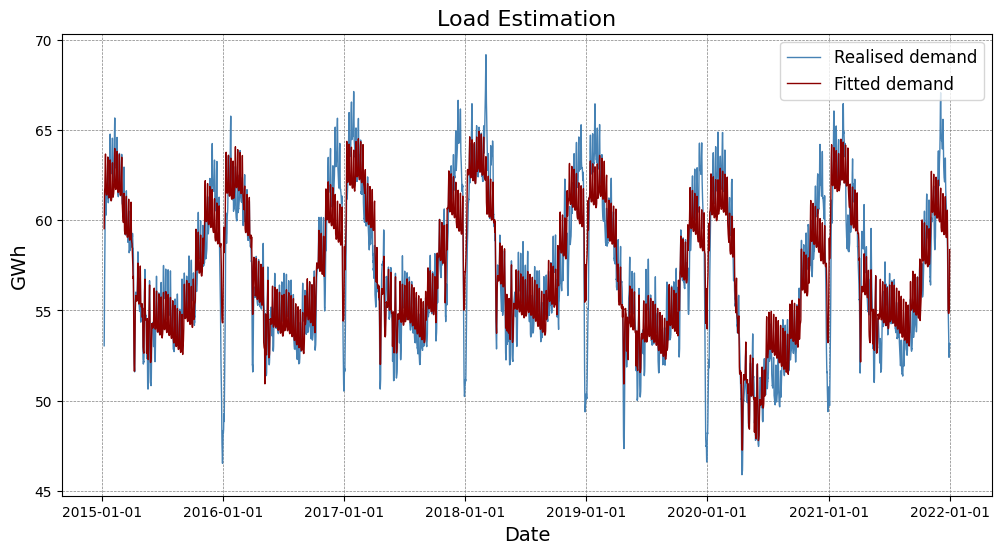

In [11]:
# Assuming load_smoothed and fit_smoothed are already defined
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the data with improved styling# Plotting the data with improved styling
ax.plot(demand_df.index, load_smoothed, color='steelblue', linewidth=1, linestyle='-', label='Realised demand')
ax.plot(demand_df.index, fit_smoothed, color='darkred', linewidth=1, linestyle='-', label='Fitted demand')

# Setting axis labels with larger fonts
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('GWh', fontsize=14)

# Setting the title with a larger font
ax.set_title('Load Estimation', fontsize=16)

# Formatting the x-axis with a date formatter
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)

# Adding a legend with a larger font and a frame
ax.legend(frameon=True, facecolor="white", loc='upper right', fontsize=12)

# Adding a grid with light color
ax.grid(color='grey', linestyle='--', linewidth=0.5)

# Setting the background color of the figure to white
fig.patch.set_facecolor('white')

# Saving the figure with high resolution
plt.savefig(r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 01 - DIPU\graphs_results\annexes\load_estimation2.pdf", dpi=300)

# Display the plot
plt.show()

In [12]:
wind = 24

start_date = '2019-01-01 00:00:00'
end_date = '2019-12-31 23:00:00'
selected_data = demand_df[start_date:end_date]
load_smoothed = selected_data['load'].rolling(window=wind)
fit_smoothed = selected_data['fitted'].rolling(window=wind)
load_smoothed = load_smoothed.mean()/1000
fit_smoothed = fit_smoothed.mean()/1000


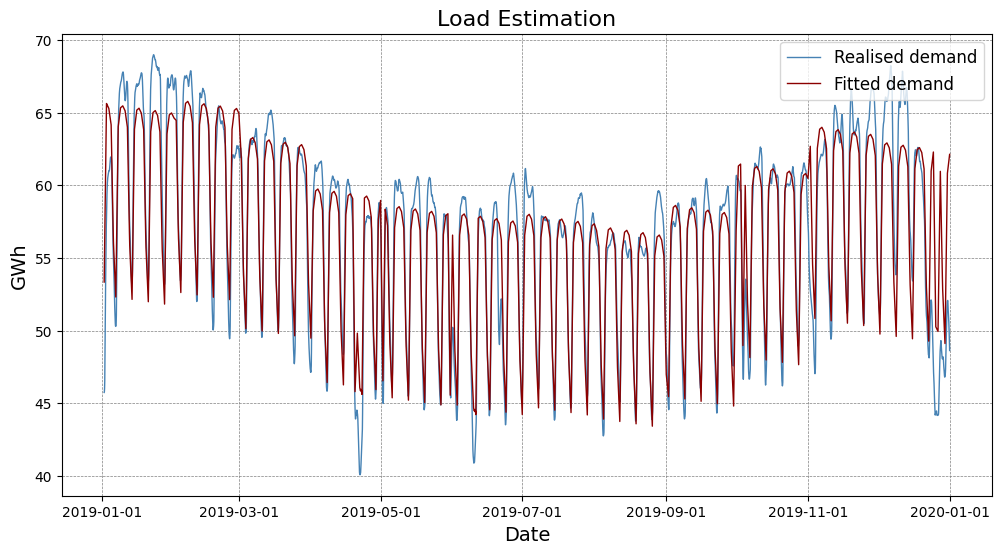

In [13]:

# Plotting the data with improved styling
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(selected_data.index, load_smoothed, color='steelblue', linewidth=1, linestyle='-', label='Realised demand')
ax.plot(selected_data.index, fit_smoothed, color='darkred', linewidth=1, linestyle='-', label='Fitted demand')

# Setting axis labels with larger fonts
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('GWh', fontsize=14)

# Setting the title with a larger font
ax.set_title('Load Estimation', fontsize=16)

# Formatting the x-axis with a date formatter
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)

# Adding a legend with a larger font and a frame
ax.legend(frameon=True, facecolor="white", loc='upper right', fontsize=12)

# Adding a grid with light color
ax.grid(color='grey', linestyle='--', linewidth=0.5)

# Setting the background color of the figure to white
fig.patch.set_facecolor('white')

# Saving the figure with high resolution
plt.savefig(r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 01 - DIPU\graphs_results\annexes\load_estimation2019.pdf", dpi=300)

# Display the plot
plt.show()


In [14]:
D_year = {}

demand_df['month'] = demand_df.index.month
demand_df['day'] = demand_df.index.day

for i in range(demand_df['year'].nunique()):
    year_aim = demand_df['year'].min()+i
    D_year[year_aim] = demand_df[demand_df['year']==year_aim][['hour', 'day', 'month', 'residuals', 'fitted']]
    D_year[year_aim] = demand_df[demand_df['year']==year_aim][['hour', 'day', 'month', 'residuals', 'fitted']]
    print(D_year[year_aim])
    D_year[year_aim] = D_year[year_aim].rename(columns={'residuals': 'residuals_'+str(year_aim), 'fitted': 'fitted_'+str(year_aim)})

df_list = [v for k,v in D_year.items()]

df = reduce(lambda df1,df2: pd.merge(df1,df2,on=['day', 'month', 'hour']), df_list)

print(df)

                           hour  day  month     residuals        fitted
date_column                                                            
2015-01-01 00:00:00+00:00     0    1      1   1352.686832  43247.563168
2015-01-01 01:00:00+00:00     1    1      1   1564.149679  41890.600321
2015-01-01 02:00:00+00:00     2    1      1    412.656523  41550.593477
2015-01-01 03:00:00+00:00     3    1      1  -1526.932839  42144.682839
2015-01-01 04:00:00+00:00     4    1      1  -4051.305053  43988.055053
...                         ...  ...    ...           ...           ...
2015-12-31 19:00:00+00:00    19   31     12 -14179.458004  66707.458004
2015-12-31 20:00:00+00:00    20   31     12 -14643.875485  63934.125485
2015-12-31 21:00:00+00:00    21   31     12 -13715.535145  61132.285145
2015-12-31 22:00:00+00:00    22   31     12 -10922.773413  58001.023413
2015-12-31 23:00:00+00:00    23   31     12  -7603.456924  52885.456924

[8760 rows x 5 columns]
                           hour  day  m

In [15]:
df['year'] = 2000
df = df.set_index(pd.to_datetime(df[['year', 'month', 'day', 'hour']])).drop(columns=['year', 'month', 'day', 'hour'])

df.to_csv(r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 01 - DIPU\Estimation\load\load2.csv")

In [16]:
s = np.random.randint(2015,2021,10)

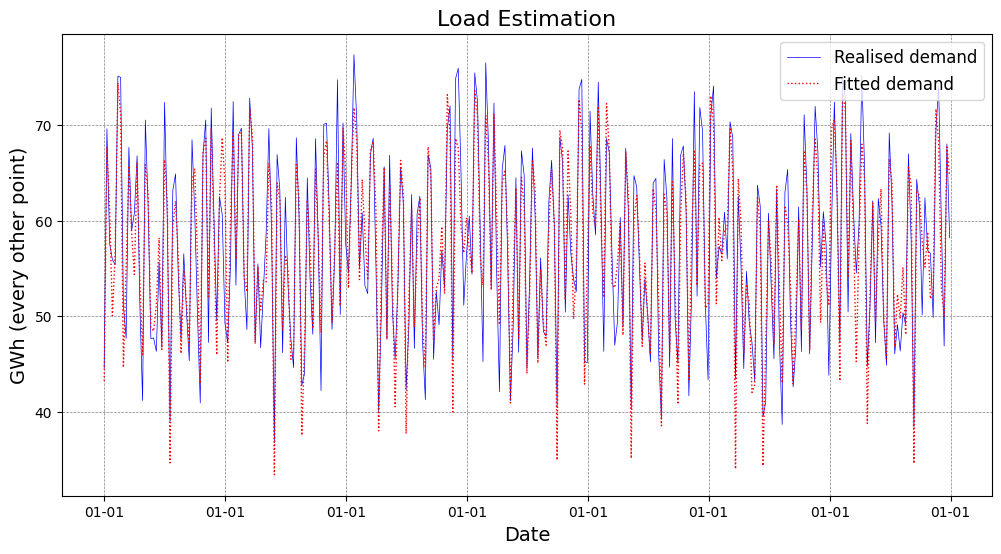

In [17]:
slice = 199

# Slice the data to plot every other point
load_smoothed = demand_df['load'][::slice]
fit_smoothed = demand_df['fitted'][::slice]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the data with improved styling
ax.plot(load_smoothed.index, load_smoothed / 1000, color='blue', linewidth=0.5, label='Realised demand')
ax.plot(fit_smoothed.index, fit_smoothed / 1000, color='red', linestyle='dotted', linewidth=1, label='Fitted demand')

# Setting axis labels with larger fonts
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('GWh (every other point)', fontsize=14)

# Setting the title with a larger font
ax.set_title('Load Estimation', fontsize=16)

# Formatting the x-axis with a date formatter
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)

# Adding a legend with a larger font and a frame
ax.legend(frameon=True, facecolor="white", loc='upper right', fontsize=12)

# Adding a grid with light color
ax.grid(color='grey', linestyle='--', linewidth=0.5)

# Setting the background color of the figure to white
fig.patch.set_facecolor('white')

# Saving the figure with high resolution
plt.savefig(r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 01 - DIPU\Estimation\load\demand_20152.png", dpi=300)

# Display the plot
plt.show()

In [18]:
load_data = pd.read_csv(r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 01 - DIPU\Estimation\load\load2.csv", index_col=0)
favorable_load = np.array(load_data['fitted_2021']+load_data['residuals_2021'])
favorable_load[:1897] *= 1.12 # 20 March 
favorable_load[:8497] *= 1.12
favorable_shock = load_data['fitted_2021']-favorable_load
load_data["low_shock"] = favorable_shock

bad_load = np.array(load_data['fitted_2021']+load_data['residuals_2021'])
bad_load[:1897] *= 0.88 # 20 March 
bad_load[:8497] *= 0.88
bad_shock = load_data['fitted_2021']-bad_load
load_data["high_shock"] = bad_shock

load_data

,residuals_2015,fitted_2015,residuals_2016,fitted_2016,residuals_2017,fitted_2017,residuals_2018,fitted_2018,residuals_2019,fitted_2019,residuals_2020,fitted_2020,residuals_2021,fitted_2021,low_shock,high_shock
2000-01-01 00:00:00,1352.686832,43247.563168,1402.187361,42212.562639,15758.976150,31193.023850,2393.271800,43039.978200,200.624377,43064.875623,1008.706910,42485.293090,1954.794376,42631.205624,-13297.472776,8103.807224
2000-01-01 01:00:00,1564.149679,41890.600321,976.150208,40855.599792,15808.438998,29836.061002,2586.984647,41683.015353,-53.912776,41707.912776,1484.169757,41128.330243,1558.007223,41274.242777,-12454.531623,8104.948377
2000-01-01 02:00:00,412.656523,41550.593477,-345.342948,40515.592948,14811.945841,29496.054159,1852.741491,41343.008509,-1254.155932,41367.905932,699.676601,40788.323399,176.514067,40934.235933,-10635.088867,9098.071133
2000-01-01 03:00:00,-1526.932839,42144.682839,-1934.932311,41109.682311,12978.106479,30090.143521,590.402129,41937.097871,-2648.995294,41961.995294,-1080.662761,41382.412761,-1164.075295,41528.325295,-9104.589905,10270.250095
2000-01-01 04:00:00,-4051.305053,43988.055053,-4191.804524,42953.054524,10316.234265,31933.515735,-1264.720085,43780.470085,-4708.117508,43805.367508,-2929.034975,43225.784975,-3053.947509,43371.697509,-7202.888091,12149.631909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00,-14179.458004,66707.458004,-1142.602752,56597.852752,-387.654555,53483.154555,-11816.123036,66499.873036,-14491.770459,66524.770459,-10620.082192,65607.832192,-10305.600460,66091.100460,10305.600460,10305.600460
2000-12-31 20:00:00,-14643.875485,63934.125485,-2015.520233,53824.520233,-1280.322036,50709.822036,-12627.040517,63726.540517,-14752.687940,63751.437940,-11814.749673,62834.499673,-11469.017941,63317.767941,11469.017941,11469.017941
2000-12-31 21:00:00,-13715.535145,61132.285145,-1337.429893,51022.679893,-681.481696,47907.981696,-11811.450177,60924.700177,-13714.097600,60949.597600,-11351.409333,60032.659333,-11764.177601,60515.927601,11764.177601,11764.177601
2000-12-31 22:00:00,-10922.773413,58001.023413,1920.081839,47891.418161,2124.780037,44776.719963,-9270.688444,57793.438444,-11006.335867,57818.335867,-9450.397600,56901.397600,-9923.415869,57384.665869,9923.415869,9923.415869
